# 모듈 및 데이터 불러오기

In [1]:
import os

import pandas as pd
import numpy as np

import copy

from time import strftime
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
os.listdir('./data/')

['random_other_ch_data_gmmpg_js.xlsx', 'random_mall_data_gmmpg_js.xlsx']

## 자사몰 데이터 

In [3]:
direct = pd.read_excel('./data/random_mall_data_gmmpg_js.xlsx')
direct.head(2)

,order_dt,user_id,order_amt,user_nm,user_tel
0,2011-03-16 19:31:47.014,118482,1499623,mEiSkKq,5890
1,2011-03-16 19:54:25.750,31587,4270813,FRszLJO,8004


In [4]:
direct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   order_dt   700000 non-null  datetime64[ns]
 1   user_id    700000 non-null  int64         
 2   order_amt  700000 non-null  int64         
 3   user_nm    700000 non-null  object        
 4   user_tel   700000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 26.7+ MB


## 외부 채널 데이터 

In [5]:
other_ch = pd.read_excel('./data/random_other_ch_data_gmmpg_js.xlsx')
other_ch.head(2)

,order_dt,user_id,user_nm,user_tel
0,2019-04-01 00:13:04.668,wktybtajus,RYBfpct,160
1,2019-04-01 00:15:23.690,oieuutxvfu,pNcqkuI,6889


In [6]:
other_ch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   order_dt  200000 non-null  datetime64[ns]
 1   user_id   200000 non-null  object        
 2   user_nm   200000 non-null  object        
 3   user_tel  200000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 6.1+ MB


# 데이터 전처리

## 공통 ID 값 매칭 및 데이터 결합

- 자사몰의 user_id와 외부 채널의 user_id는 다른 id값이기 때문에 mapping에 활용 불가능
- 고객 이름과 전화번호 뒷자리 각각은 동명이인이 있거나 뒷자리가 동일할 수 있기 때문에 고유한 key값으로 활용 불가능
- 따라서 2개 속성값을 결합하여 고유한 key값으로 지정해야 함: 고객 이름 + 전화번호 뒷자리 결합

In [7]:
direct['com_id'] = direct['user_nm'] + direct['user_tel'].apply(str)
other_ch['com_id'] = other_ch['user_nm'] + other_ch['user_tel'].apply(str)

In [8]:
com_df = pd.merge(direct, other_ch[['user_id', 'com_id']], how='left', on='com_id')
com_id_li = com_df.loc[com_df.user_id_y.notnull(), 'com_id'].unique()
print('매핑된 공통ID 예시: ', com_id_li[:5], '개수: ',len(com_id_li))

매핑된 공통ID 예시:  ['FRszLJO8004' 'fRaJRik7043' 'bcYLNDl5025' 'nCfQRko368' 'fnRRUwy7012'] 개수:  35978


In [9]:
direct['channel'] = 'direct'
other_ch['channel'] = 'others'

In [10]:
total = pd.concat([direct[['order_dt', 'user_id', 'user_nm', 'user_tel', 'com_id','channel']], other_ch])
total.index = range(len(total))

total.head(3)

,order_dt,user_id,user_nm,user_tel,com_id,channel
0,2011-03-16 19:31:47.014,118482,mEiSkKq,5890,mEiSkKq5890,direct
1,2011-03-16 19:54:25.750,31587,FRszLJO,8004,FRszLJO8004,direct
2,2011-03-16 20:03:34.055,69752,zELLCDT,9700,zELLCDT9700,direct


## 날짜 전처리

- 연 단위로 retention 분석을 수행할 것이기 때문에 년도 따로 추출 
- 분석 기간은 2012 ~ 2021 '10년'으로 한정함

In [11]:
total['year'] = total.order_dt.apply(lambda x: x.year)

In [12]:
total = total[(total.year != 2011)&(total.year != 2022)]
total.index = range(len(total))

## 고객별 첫 구매 일자(년도)

In [13]:
fst_df = pd.pivot_table(total, values=['order_dt'], index = ['com_id'], aggfunc={'order_dt': min})
fst_df.reset_index(inplace=True)

fst_df.head(3)

,com_id,order_dt
0,AAANCJUFBX4203,2019-06-23 13:30:19.697
1,AAANCJUFBX4691,2019-05-22 07:41:29.001
2,AAANCJUFBX8059,2021-07-02 12:57:32.823


In [14]:
total = pd.merge(total, fst_df, how='left', on='com_id')
total.columns = ['order_dt', 'user_id', 'user_nm', 'user_tel', 'com_id', 'channel', 'order_year', 'fst_order_dt']

total['fst_order_year'] = total['fst_order_dt'].apply(lambda x: x.year)

total.head(2)

,order_dt,user_id,user_nm,user_tel,com_id,channel,order_year,fst_order_dt,fst_order_year
0,2012-01-01 00:01:38.086,37187,wuXjvEE,7449,wuXjvEE7449,direct,2012,2012-01-01 00:01:38.086,2012
1,2012-01-01 00:04:20.381,19246,nTzMFqB,9439,nTzMFqB9439,direct,2012,2012-01-01 00:04:20.381,2012


# 연도별 신규 구매 / 재구매 추이 
- 고객 전체 즉, 자사몰과 외부 채널로부터 유입한 모든 고객에 대한 신규 및 재구매 비율 분석

## 전체 단위 분석

In [15]:
obj_df = copy.deepcopy(total)
obj_df['temp_cnt'] = 1 # pivot table 만들기 위해 임의로 부여

obj_df.head(2)

,order_dt,user_id,user_nm,user_tel,com_id,channel,order_year,fst_order_dt,fst_order_year,temp_cnt
0,2012-01-01 00:01:38.086,37187,wuXjvEE,7449,wuXjvEE7449,direct,2012,2012-01-01 00:01:38.086,2012,1
1,2012-01-01 00:04:20.381,19246,nTzMFqB,9439,nTzMFqB9439,direct,2012,2012-01-01 00:04:20.381,2012,1


In [16]:
obj_year = pd.pivot_table(obj_df, values=['temp_cnt'], 
                         index = ['com_id', 'fst_order_year', 'order_year'], 
                          aggfunc={'temp_cnt': np.mean})

obj_year = obj_year.reset_index()
obj_year.head(3)

,com_id,fst_order_year,order_year,temp_cnt
0,AAANCJUFBX4203,2019,2019,1
1,AAANCJUFBX4691,2019,2019,1
2,AAANCJUFBX8059,2021,2021,1


In [17]:
# 구매 간격 구하기 

obj_year['years_from'] = obj_year['order_year']-obj_year['fst_order_year']

In [18]:
obj_year.columns = ['userid', 'fst_order_year', 'order_year', 'avg_temp_cnt', 'years_from']
obj_year.head(3)

,userid,fst_order_year,order_year,avg_temp_cnt,years_from
0,AAANCJUFBX4203,2019,2019,1,0
1,AAANCJUFBX4691,2019,2019,1,0
2,AAANCJUFBX8059,2021,2021,1,0


In [19]:
# 재구매 여부 구분
# 0인 경우는 첫 구매 
# 0이 아닌 경우는 재구매

obj_year.loc[obj_year.years_from == 0, 're_purchase'] = False
obj_year.loc[obj_year.years_from != 0, 're_purchase'] = True

In [20]:
group = obj_year.groupby(['order_year', 're_purchase'])
yearly_data = group['userid'].size()

yearly_data = yearly_data.reset_index()
yearly_data.columns = ['order_year', 're_purchase', 'user_cnt']
yearly_data.head(3)

,order_year,re_purchase,user_cnt
0,2012,False,52266
1,2013,False,33954
2,2013,True,18311


In [21]:
# 데이터 시각화를 위한 데이터 전처리 

yearly_data = pd.concat([pd.DataFrame({'order_year': 2012, 're_purchase': True, 'user_cnt': 0}, index = [0]), yearly_data])

temp_true = yearly_data.loc[(yearly_data.re_purchase == True)&(yearly_data.order_year == 2012), 'user_cnt'].item()
temp_false = yearly_data.loc[(yearly_data.re_purchase == False)&(yearly_data.order_year == 2012), 'user_cnt'].item()

yearly_data.loc[(yearly_data.re_purchase == False)&(yearly_data.order_year == 2012), 'user_cnt'] = temp_true
yearly_data.loc[(yearly_data.re_purchase == True)&(yearly_data.order_year == 2012), 'user_cnt'] = temp_false

yearly_data.loc[(yearly_data.user_cnt == temp_true)&(yearly_data.order_year == 2012), 're_purchase'] = True
yearly_data.loc[(yearly_data.user_cnt == temp_false)&(yearly_data.order_year == 2012), 're_purchase'] = False

yearly = yearly_data.loc[yearly_data.order_year == 2012, ['re_purchase', 'user_cnt']]
yearly.index = range(len(yearly))

for i in range(2013, 2022):
    temp_df = yearly_data.loc[yearly_data.order_year == i, ['user_cnt']]
    temp_df.index =range(len(temp_df))
    
    yearly = pd.concat([yearly, temp_df], axis = 1)

yearly.set_index('re_purchase', inplace=True)
yearly.columns = list(range(2012, 2022))

yearly = yearly.transpose()
yearly['Total'] = yearly[False] + yearly[True]

yearly = yearly.transpose()
yearly

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
re_purchase,,,,,,,,,,
False,52266,33954,22458,14451,9434,6036,3923,18723,22518,21802
True,0,18311,30032,37814,43053,46537,48443,64585,68636,69277
Total,52266,52265,52490,52265,52487,52573,52366,83308,91154,91079


In [22]:
# 그래프에 표시할 값 데이터 생성 

bar_text_t = yearly_data.loc[yearly_data.re_purchase == True, 'user_cnt']
bar_text_t.index = range(len(bar_text_t))

bar_text_f = yearly_data.loc[yearly_data.re_purchase == False, 'user_cnt']
bar_text_f.index = range(len(bar_text_f))

bar_text = pd.DataFrame(bar_text_t + bar_text_f)
bar_text['re_purchase_ratio'] = bar_text_t / bar_text['user_cnt']

bar_text = bar_text.transpose().apply(lambda data: str(int(data['user_cnt']))+'\n'+'('+ str(round(data['re_purchase_ratio']*100, 2))+'%'+')')
bar_text[0] = 52266

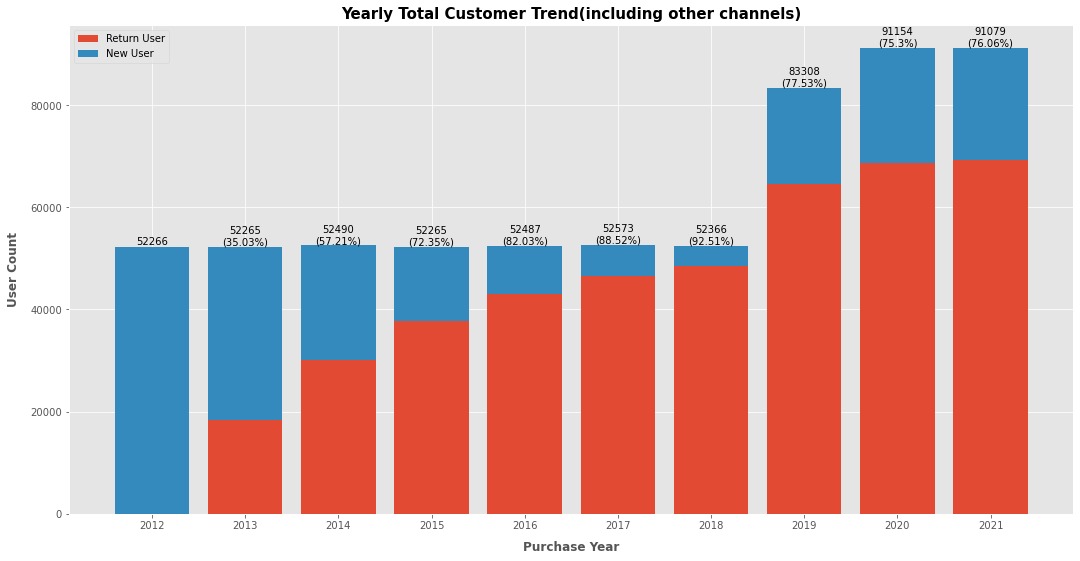

In [23]:
plt.figure(figsize=(18,9))
plt.style.use(['ggplot'])

plt.title('Yearly Total Customer Trend(including other channels)', fontweight='bold', fontsize=15)

plt.bar(yearly_data.loc[yearly_data.re_purchase == True, 'order_year'], 
        yearly_data.loc[yearly_data.re_purchase == True, 'user_cnt'])

plt.bar(yearly_data.loc[yearly_data.re_purchase == False, 'order_year'], 
        yearly_data.loc[yearly_data.re_purchase == False, 'user_cnt'],
        bottom = yearly_data.loc[yearly_data.re_purchase == True, 'user_cnt'])

plt.xticks(yearly_data.loc[yearly_data.re_purchase == False, 'order_year'], yearly_data.loc[yearly_data.re_purchase == False, 'order_year'])

for i, v in enumerate(yearly_data.loc[yearly_data.re_purchase == False, 'order_year']):
    plt.text(v, (bar_text_t + bar_text_f)[i], bar_text[i],     # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
#              color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

    
plt.xlabel('Purchase Year', labelpad=10, fontweight='bold')
plt.ylabel('User Count', labelpad=10, fontweight='bold')    
plt.legend(('Return User', 'New User'))

# plt.savefig("Yearly Total Customer Trend(including other channels)_10year.png")
    
plt.show()

## 자사몰 vs. 외부 채널 각각 신규 및 재구매 비율 비교

In [24]:
obj_year_indiv = pd.pivot_table(obj_df, values=['temp_cnt'], 
                                 index = ['com_id', 'channel', 'fst_order_year', 'order_year'], 
                                  aggfunc={'temp_cnt': np.mean})
obj_year_indiv

temp_cnt
com_id         channel fst_order_year order_year          
AAANCJUFBX4203 others  2019           2019               1
AAANCJUFBX4691 others  2019           2019               1
AAANCJUFBX8059 others  2021           2021               1
AAANCJUFBX8481 others  2021           2021               1
AAANCJUFBX9037 others  2021           2021               1
...                                                    ...
zzzwJmK6496    direct  2013           2013               1
                                      2014               1
                                      2016               1
                                      2019               1
                                      2020               1

[659710 rows x 1 columns]

In [25]:
obj_year_indiv = obj_year_indiv.reset_index()

obj_year_indiv['years_from'] = obj_year_indiv['order_year']-obj_year_indiv['fst_order_year']
obj_year_indiv.columns = ['com_id', 'channel', 'fst_order_year', 'order_year', 'avg_temp_cnt', 'years_from']

obj_year_indiv.loc[obj_year_indiv.years_from == 0, 're_purchase'] = False
obj_year_indiv.loc[obj_year_indiv.years_from != 0, 're_purchase'] = True

obj_year_indiv.head(3)

,com_id,channel,fst_order_year,order_year,avg_temp_cnt,years_from,re_purchase
0,AAANCJUFBX4203,others,2019,2019,1,0,False
1,AAANCJUFBX4691,others,2019,2019,1,0,False
2,AAANCJUFBX8059,others,2021,2021,1,0,False


In [26]:
group = obj_year_indiv.groupby(['order_year', 're_purchase', 'channel'])
yearly_indiv_data = group['com_id'].size()

yearly_indiv_data = yearly_indiv_data.reset_index()

yearly_indiv_data.columns = ['order_year', 're_purchase', 'channel', 'user_cnt']
yearly_indiv_data.head(3)

,order_year,re_purchase,channel,user_cnt
0,2012,False,direct,52266
1,2013,False,direct,33954
2,2013,True,direct,18311


In [27]:
re_yearly_data = []

for o_y in yearly_indiv_data.order_year.unique():
    
    if o_y in [2019, 2020, 2021]:
        re_st_data = {'Direct-New' : yearly_indiv_data.loc[(yearly_indiv_data.order_year == o_y)&(yearly_indiv_data.re_purchase == False)&\
                                                   (yearly_indiv_data.channel == 'direct'), 'user_cnt'].sum(),
                     'Direct-Return': yearly_indiv_data.loc[(yearly_indiv_data.order_year == o_y)&(yearly_indiv_data.re_purchase != False)&\
                                                    (yearly_indiv_data.channel =='direct'), 'user_cnt'].sum(),
                     'Other-New': yearly_indiv_data.loc[(yearly_indiv_data.order_year == o_y)&(yearly_indiv_data.re_purchase == False)&\
                                                   (yearly_indiv_data.channel == 'others'), 'user_cnt'].item(),
                     'Other-Return': yearly_indiv_data.loc[(yearly_indiv_data.order_year == o_y)&(yearly_indiv_data.re_purchase != False)&\
                                                    (yearly_indiv_data.channel == 'others'), 'user_cnt'].item()}
    else:
        re_st_data = {'Direct-New' : yearly_indiv_data.loc[(yearly_indiv_data.order_year == o_y)&(yearly_indiv_data.re_purchase == False), 'user_cnt'].sum(),
                     'Direct-Return': yearly_indiv_data.loc[(yearly_indiv_data.order_year == o_y)&(yearly_indiv_data.re_purchase != False), 'user_cnt'].sum(),
                     'Other-New': 0,
                     'Other-Return': 0}
    
    re_yearly_data.append(re_st_data)
    

In [28]:
re_yearly_df = pd.DataFrame(re_yearly_data)
re_yearly_df.index = range(2012, 2022)

re_yearly_df

,Direct-New,Direct-Return,Other-New,Other-Return
2012,52266,0,0,0
2013,33954,18311,0,0
2014,22458,30032,0,0
2015,14451,37814,0,0
2016,9434,43053,0,0
2017,6036,46537,0,0
2018,3923,48443,0,0
2019,2593,49832,16559,22585
2020,1470,51215,21166,26946
2021,901,51618,20925,27188


In [29]:
re_yearly_df['Total'] = re_yearly_df.transpose().sum()

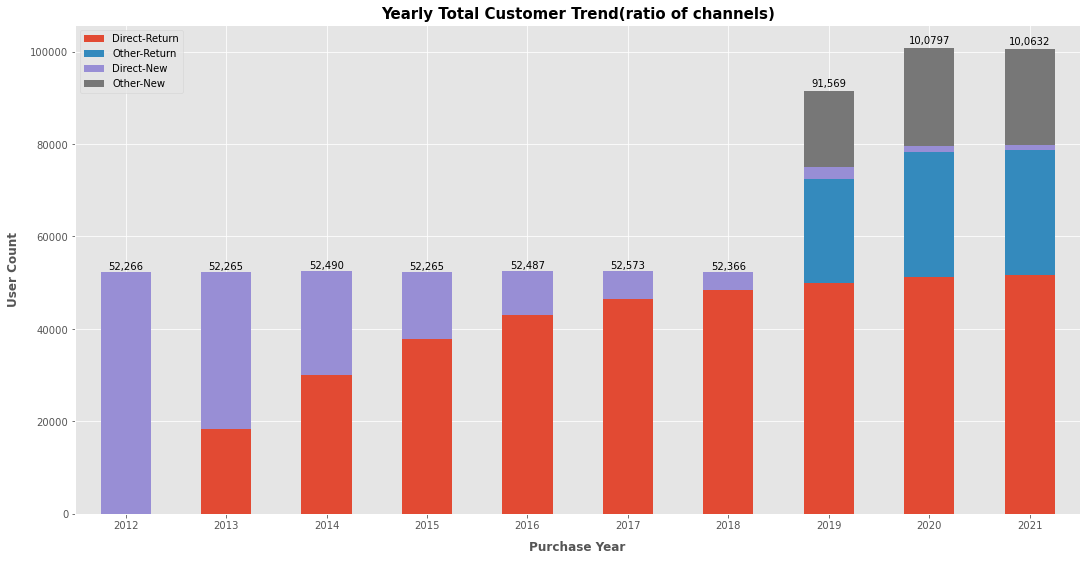

In [30]:
plt.style.use(['ggplot'])

ax = re_yearly_df[['Direct-Return', 'Other-Return', 'Direct-New', 'Other-New']].plot.bar(stacked=True, figsize=(18,9))
plt.title('Yearly Total Customer Trend(ratio of channels)', fontweight='bold', fontsize=15)

plt.xlabel('Purchase Year', labelpad=10, fontweight='bold')
plt.ylabel('User Count', labelpad=10, fontweight='bold')  

for p, t in zip(ax.patches, re_yearly_df['Total']):
#     print(p, t)
#     print('---', p)
    left, bottom, width, height = p.get_bbox().bounds
    height = int(t)
#     print(left, bottom, width, height)
    ax.annotate(str(height)[:2]+','+str(height)[2:], (left+width/2, height*1.01), ha='center')


plt.legend(('Direct-Return', 'Other-Return', 'Direct-New', 'Other-New'))
plt.xticks(rotation=360)

# plt.savefig("Yearly Total Customer Trend(ratio of channels)_10year.png")
plt.show()

# 재구매 퍼널 분석

In [31]:
obj_df['row_number'] = obj_df.groupby('com_id').cumcount() + 1

purchase_cnt = pd.pivot_table(obj_df, values=['com_id'], index = ['row_number'], aggfunc={'com_id': 'count'})

purchase_cnt.reset_index(inplace=True)
purchase_cnt.columns = ['purchase_num', 'count']

purchase_cnt = purchase_cnt.loc[purchase_cnt.purchase_num <= 10]
purchase_cnt['lag'] = purchase_cnt['count'].shift(1)

purchase_cnt

,purchase_num,count,lag
0,1,205565,NaN
1,2,141527,205565.0
2,3,127078,141527.0
3,4,105858,127078.0
4,5,81826,105858.0
5,6,59570,81826.0
6,7,41577,59570.0
7,8,28346,41577.0
8,9,19014,28346.0
9,10,12575,19014.0


In [32]:
purchase_cnt['convg_rate'] = purchase_cnt['count'] / purchase_cnt['lag']

In [33]:
bar_text = purchase_cnt['count'].apply(str)+'\n'+'('+purchase_cnt.convg_rate.apply(lambda x: str(round(x*100, 2))+'%')+')'

In [34]:
bar_text[0] = 205565

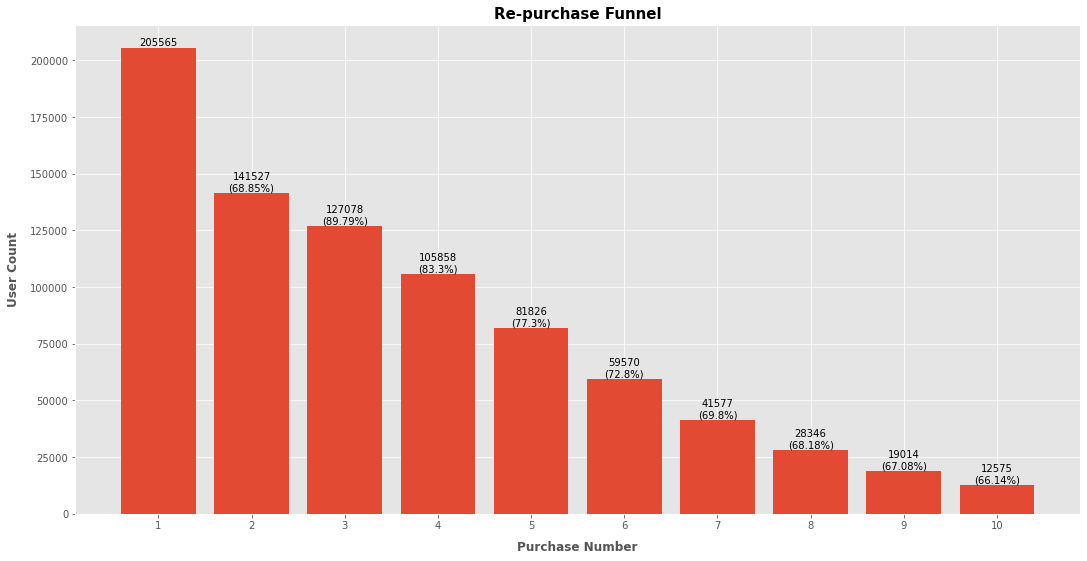

In [35]:
plt.figure(figsize=(18,9))

plt.style.use(['ggplot'])

plt.title('Re-purchase Funnel', fontweight='bold', fontsize=15)

plt.bar(purchase_cnt['purchase_num'], purchase_cnt['count'])
plt.xticks(purchase_cnt['purchase_num'], purchase_cnt['purchase_num'])

for i, v in enumerate(purchase_cnt['purchase_num']):
    plt.text(v, purchase_cnt['count'][i], bar_text[i],     # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
#              color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.xlabel('Purchase Number', labelpad=10, fontweight='bold')
plt.ylabel('User Count', labelpad=10, fontweight='bold')

# plt.savefig("Re-purchase Funnel_10year.png")

plt.show()

# 코호트 분석

In [36]:
group = obj_year.groupby(['fst_order_year', 'years_from'])
cohort_data = group['userid'].size()

cohort_data = cohort_data.reset_index()
cohort_data.columns = ['cohort', 'years_from', 'user_cnt']

cohort_data.head(3)

,cohort,years_from,user_cnt
0,2012,0,52266
1,2012,1,18311
2,2012,2,18216


In [37]:
cohort_counts = cohort_data.pivot(index='cohort', columns='years_from', values='user_cnt')
cohort_counts

years_from,0,1,2,3,4,5,6,7,8,9
cohort,,,,,,,,,,
2012,52266.0,18311.0,18216.0,18191.0,18341.0,18338.0,18307.0,23634.0,24513.0,24396.0
2013,33954.0,11816.0,11808.0,11806.0,11908.0,11850.0,15335.0,16059.0,16027.0,NaN
2014,22458.0,7815.0,7872.0,7826.0,7891.0,10137.0,10444.0,10643.0,NaN,NaN
2015,14451.0,5034.0,5105.0,5094.0,6649.0,6750.0,6746.0,NaN,NaN,NaN
2016,9434.0,3360.0,3246.0,4362.0,4468.0,4479.0,NaN,NaN,NaN,NaN
2017,6036.0,2055.0,2707.0,2841.0,2847.0,NaN,NaN,NaN,NaN,NaN
2018,3923.0,1761.0,1859.0,1830.0,NaN,NaN,NaN,NaN,NaN,NaN
2019,18723.0,1702.0,1653.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,22518.0,656.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
base = cohort_counts[0] # 각 cohort의 첫 구매

In [39]:
retention = cohort_counts.divide(base, axis=0).round(3)
retention

years_from,0,1,2,3,4,5,6,7,8,9
cohort,,,,,,,,,,
2012,1.0,0.350,0.349,0.348,0.351,0.351,0.350,0.452,0.469,0.467
2013,1.0,0.348,0.348,0.348,0.351,0.349,0.452,0.473,0.472,NaN
2014,1.0,0.348,0.351,0.348,0.351,0.451,0.465,0.474,NaN,NaN
2015,1.0,0.348,0.353,0.353,0.460,0.467,0.467,NaN,NaN,NaN
2016,1.0,0.356,0.344,0.462,0.474,0.475,NaN,NaN,NaN,NaN
2017,1.0,0.340,0.448,0.471,0.472,NaN,NaN,NaN,NaN,NaN
2018,1.0,0.449,0.474,0.466,NaN,NaN,NaN,NaN,NaN,NaN
2019,1.0,0.091,0.088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,1.0,0.029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
retention_text = copy.deepcopy(retention)

for year in range(2012, 2022):
    idx = retention.loc[year][retention.loc[year].notnull()].index
    for y_f in idx:
        retention_text.loc[year, y_f] = str(round(retention.loc[year, y_f]*100,2))+'%' + '\n' + '(' + str(int(cohort_counts.loc[year, y_f]))+')'

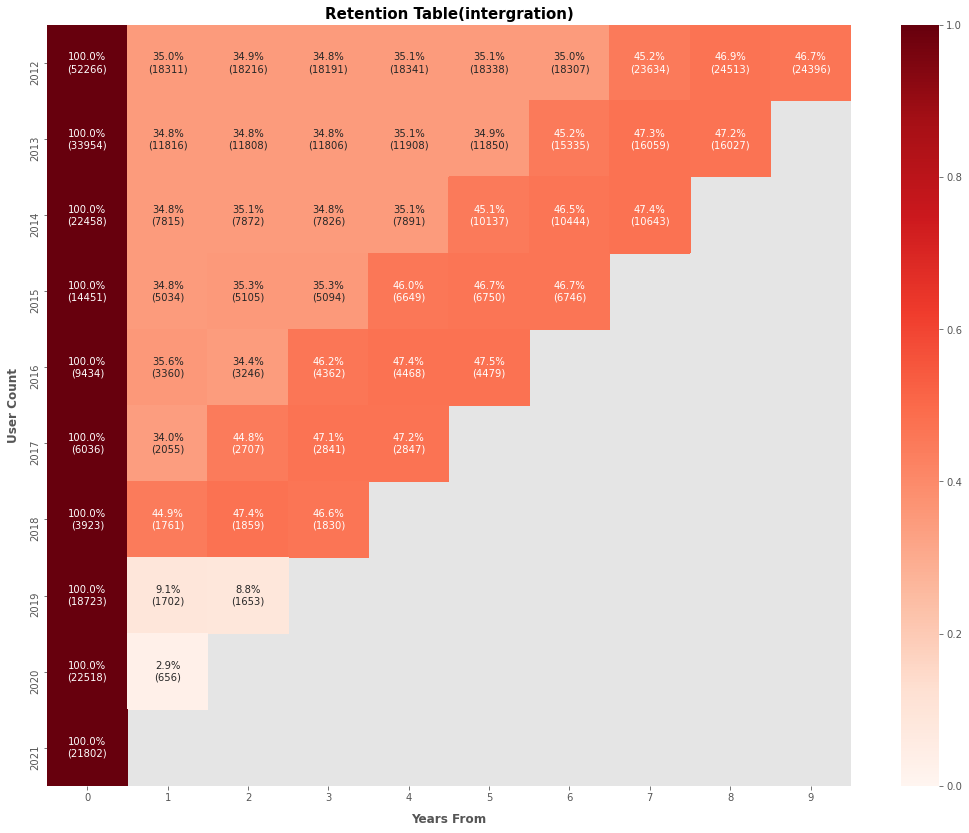

In [41]:
plt.figure(figsize=(18,14))
plt.style.use(['ggplot'])

plt.title('Retention Table(intergration)', fontweight='bold', fontsize=15)
ax = sns.heatmap(data=retention, annot=np.array(retention_text), fmt="", vmin=0.0, vmax=1,cmap='Reds')
ax.set_yticklabels(retention.index)

plt.xlabel('Years From', labelpad=10, fontweight='bold')
plt.ylabel('User Count', labelpad=10, fontweight='bold')

fig=ax.get_figure()
# fig.savefig("Retention_Rate(intergration)_10year.png")

plt.show()